In [1]:
from __future__ import print_function
from fenics import *
import numpy as np
import dolfin as df
import os 
import matplotlib.pyplot as plt

# Create mesh and define function space

l = 1.0 
p0 = (0.0, 0.0, 0.0)
p1 = (l, l, 0.0)
nx = 20.0
ny = 20.0
nz = 1.0
#point source de chaleur
p2=(5., 5.)
LL = 0.3 
cp=1.

mesh = BoxMesh(Point(0,0, 0), Point(0.3, 0.3, 0.3/20), 10, 10, 10 )

plot(mesh)


## donnees materiaux

In [2]:
#titane= Ta6V (titane+alu)
Eta= 115.E9   # module d'young Pa
rhota= 5000.   # kg/m^3
stressmaxta = 1.1E9   #Pa resistance à la traction
nuta=0.25   
lbdta=(nuta*Eta)/((1+nuta)*(1-2*nuta))  #Pa
cpvta=0.12  #(J/(m^3*K))
cpta= 550.   #J/(kg*K)
#contrainte max avant que ca casse

In [3]:
#acier
Eacier=210.E9
rhoacier= 7800.
nuacier=0.3
lbdacier=(nuacier*Eacier)/((1+nuacier)*(1-2*nuacier))
cpacier=  466.    #J/(kg*K)
cpvacier = 3.756E6   #J/(m^3*K)


In [4]:
#inconel
Einc=207.E9
rhoinc= 8470.
stressmaxinc = 600.E6   #Pa à 100°C
nuinc=0.3
lbdinc=(nuinc*Einc)/((1+nuinc)*(1-2*nuinc))
print(lbdinc)
cpinc=  496.    #J/(kg*K) à 100°C


119423076923.07692


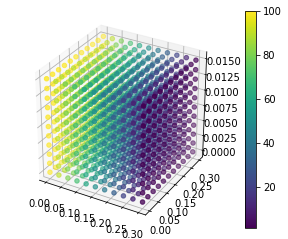

In [5]:
Tfin = 2000.0            # final time
num_steps = 10     # number of time steps
dt = Tfin / num_steps # time step size
alpha = 3          # parameter alpha
beta = 1.2         # parameter beta
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
#solution arbitraire
u_D = Expression('1 + x[0]*x[0] + alpha*x[1]*x[1] + beta*t',
                 degree=2, alpha=alpha, beta=beta, t=0)


class NoslipBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (x[0] < DOLFIN_EPS )

class NoslipBoundary2(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and ( x[0] > LL - DOLFIN_EPS) 
        
#class NoslipBoundary2(SubDomain):
#    def inside(self, x, on_boundary):
#        return on_boundary and (x[1] > 1.0 - DOLFIN_EPS or x[1] < DOLFIN_EPS) 

b_T = [DirichletBC(V, Constant(100.0), NoslipBoundary()), 
       DirichletBC(V, Constant(1.), NoslipBoundary2())] 

# Define initial value
u_n = interpolate(u_D, V)
#u_n = project(u_D, V)

# Define variational problem
du = TrialFunction(V)
v = TestFunction(V)
f = Constant(0.)
u = Function(V)
F = du*v*dx + dt*dot(grad(u+du), grad(v))*dx - (dt*f)*v*dx
a, L = lhs(F), rhs(F)



# Time-stepping
u = Function(V)
t = 0 

for n in range(num_steps):

    # Update current time
    t += dt
    u_D.t = t

    # Compute solution
    solve(a == L, u, b_T)

    # Plot solution
    
    # Compute error at vertices
    u_e = interpolate(u_D, V) 
    # Update previous solution
    u_n.assign(u)
graph=plot(u)
#plt.colorbar(cax=x[0],0. , mappable, **kwargs)[source]
plt.colorbar(graph);

### Source ponctuelle

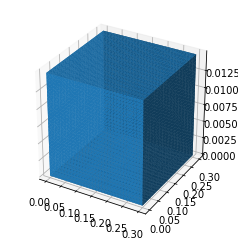

In [6]:
from dolfin import *
nbrnoeuds = 30
LL=0.3
mesh2 = BoxMesh(Point(0,0, 0), Point(LL, LL, LL/20.), nbrnoeuds, nbrnoeuds , nbrnoeuds)
plot(mesh2)

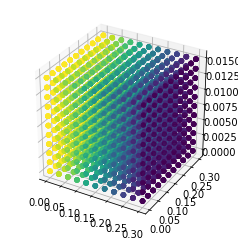

In [7]:


# Define boundary condition
#solution arbitraire
u_D = Expression('1 + x[0]*x[0] + alpha*x[1]*x[1] + beta*t',
                 degree=2, alpha=alpha, beta=beta, t=0)

class NoslipBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (x[0] < DOLFIN_EPS )

class NoslipBoundary2(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and ( x[0] > LL - DOLFIN_EPS) 
        
#class NoslipBoundary2(SubDomain):
#    def inside(self, x, on_boundary):
#        return on_boundary and (x[1] > 1.0 - DOLFIN_EPS or x[1] < DOLFIN_EPS) 

b_T = [DirichletBC(V, Constant(100.0), NoslipBoundary()), 
       DirichletBC(V, Constant(1.), NoslipBoundary2())] 

# Define initial value
u_n = interpolate(u_D, V)
#u_n = project(u_D, V)

# Define variational problem
du = TrialFunction(V)
v = TestFunction(V)
f = Constant(0.)

u = Function(V)
F = du*v*dx + dt*dot(grad(u+du), grad(v))*dx - (dt*f)*v*dx
a, L = lhs(F), rhs(F)


A, b = assemble_system(a, L, b_T)

delta = PointSource(V, Point(LL/2.,LL/2.,LL/20.), 1000)
delta.apply(b)


# Time-stepping
u = Function(V)
t = 0 

for n in range(num_steps):

    # Update current time
    t += dt
    u_D.t = t

    # Compute solution
    solve(a == L, u, b_T)

    # Plot solution
    
    # Compute error at vertices
    u_e = interpolate(u_D, V) 
    # Update previous solution
    u_n.assign(u)
    graph=plot(u)
   #plt.colorbar(graph);


##ne fonctionne pas mais utile

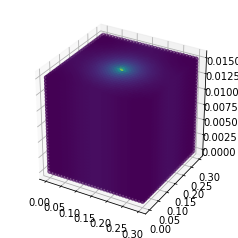

In [8]:

V = FunctionSpace(mesh2,"CG", 1)
du = TrialFunction(V)
v = TestFunction(V)
f = Constant(0.)

u = Function(V)
F = du*v*dx + dt*dot(grad(u+du), grad(v))*dx - (dt*f)*v*dx
a, L = lhs(F), rhs(F)


#a = inner(grad(u), grad(v))*dx
#L = Constant(0)*v*dx
A, l = assemble_system(a, L, b_T)

delta = PointSource(V, Point(LL/2.,LL/2.,LL/30.), 1.)
delta.apply(l)

u = Function(V)

solve(A, u.vector(),l)
plot(u)

## Avec le temps

queleuqe chose 200.0
dt 200.0
u 27.21654096929279
du 27.216540969292808
dt 200.0
u 54.43308188186093
du 27.21654093346865
dt 200.0
u 81.64962280812789
du 27.216540933559376
dt 200.0
u 108.86616373773583
du 27.2165409335808
dt 200.0
u 136.08270466877468
du 27.216540933517113
dt 200.0
u 163.29924560053516
du 27.216540933527412
dt 200.0
u 190.51578653271463
du 27.21654093361005
dt 200.0
u 217.73232746510558
du 27.21654093362131
dt 200.0
u 244.9488683976961
du 27.216540933552466
dt 200.0
u 272.1654093304209
du 27.216540933556413
dt 200.0
u 299.3819502632466
du 27.216540933633
dt 200.0
u 326.5984911961201
du 27.21654093363228
dt 200.0
u 353.8150321290538
du 27.216540933555567
dt 200.0
u 381.03157306202144
du 27.21654093355273
dt 200.0
u 408.2481139950472
du 27.21654093362293
dt 200.0
u 435.46465492806107
du 27.21654093361173
dt 200.0
u 462.68119586111203
du 27.21654093352876
dt 200.0
u 489.8977367941739
du 27.216540933518296
dt 200.0
u 517.1142777272446
du 27.2165409335809
dt 200.0
u 544.33

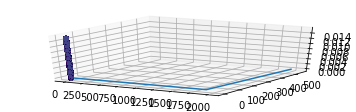

In [10]:


b_dT = [DirichletBC(V, Constant(0.), NoslipBoundary()), 
       DirichletBC(V, Constant(0.), NoslipBoundary2())]

b_dT =[]
V = FunctionSpace(mesh2,"CG", 1)
u=Function(V)#temperature field
u.assign(Constant(0.))
du = TrialFunction(V)#increment temperature # inconnu du probleme incrmeental
du_sol=Function(V)   #ce qui contient la solution du probleme incremental
v = TestFunction(V)
f = Constant(0.)
du_sol.assign(Constant(0.))
F = du*v*dx + dt*dot(grad(u+du), grad(v))*dx#- (dt*f)*v*dx



a, L = lhs(F), rhs(F)
n_steps = 20
print("queleuqe chose" ,t)
vtkfile = File('heat_gaussian/solution.pvd')
vtkfile2 = File('du/du.pvd')
t=0.
T_over_time=np.zeros(n_steps+1)
for step in range(n_steps):
   
    
    x = LL/4.+(step/n_steps)*LL/2.
    y = LL/2.
    z = LL/30.
    
    #a = inner(grad(u), grad(v))*dx
    #L = Constant(0)*v*dx
    A, b = assemble_system(a, L, b_dT)

     # Update current time
    t += dt
    print('dt',dt)
    #delta.set_point(t)
    #delta.apply(b)
    delta = PointSource(V, Point(x,y,z), 1.)
    delta.apply(b)
    
    solve(A, du_sol.vector(), b)
    u.assign(project(u+du_sol, V))
    vtkfile << (u, t)
    vtkfile2 << (du_sol, t)
    T_over_time[n_steps]=norm(u,'L2')
    
    print('u', norm(u,'L2'))
    print('du', norm(du_sol,'L2'))
    
    plot(u)
    
plt.plot( np.linspace(0.,Tfin,n_steps+1), T_over_time)
print(T_over_time)


In [ ]:
## Vitesse faisceau : trop petite/forte 0.23 m/s ? donnees machines?